In [1]:
import jax

In [2]:
jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=2, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,1,0), core_on_chip=0)]

In [3]:
import jax.numpy as jnp
from jax import random
import jax

In [5]:
x = jax.random.normal(random.PRNGKey(0), (5_000, 5_000))

print(x.shape)
print(x.dtype)

(5000, 5000)
float32


In [6]:
x

Array([[-0.11661171,  0.8242215 , -1.2445085 , ..., -1.8854173 ,
         0.41252783, -0.961976  ],
       [ 1.8455055 , -0.30786476, -1.0153097 , ..., -0.01620289,
         2.0080993 , -0.9451337 ],
       [-0.67672527,  0.4280688 , -0.46904287, ...,  0.7997399 ,
         0.10403793, -1.2848098 ],
       ...,
       [ 0.60997057, -1.3257729 , -0.86143535, ..., -2.6257322 ,
        -1.2271131 ,  0.61286527],
       [ 1.0326647 ,  0.592573  , -0.10977031, ...,  0.2430163 ,
        -0.5956606 , -1.4219506 ],
       [ 2.1604197 , -0.2298865 , -1.0518851 , ...,  1.6659708 ,
        -0.31161797,  1.3135116 ]], dtype=float32)

In [7]:
y = jnp.dot(x, jnp.cos(x))
z = y[[0, 2, 1, 0], ..., None, ::-1]

print(z)

[[[ -6.0566964  53.154293   47.546646  ... -32.643036   23.932243
   -32.559704 ]]

 [[ -2.876449   14.091277   28.160069  ...  72.67386    30.46049
    54.96488  ]]

 [[-58.108154  -35.2848    -48.49509   ... -32.48123   -15.550288
     3.571836 ]]

 [[ -6.0566964  53.154293   47.546646  ... -32.643036   23.932243
   -32.559704 ]]]


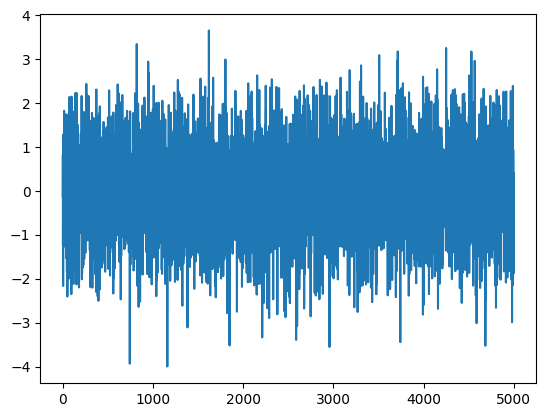

In [8]:
import matplotlib.pyplot as plt

plt.plot(x[0])

In [9]:
%timeit -n 5 -r 5 jnp.dot(x, x).block_until_ready()

1.35 ms ± 60.8 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [10]:
import numpy as np
x_cpu = np.array(x)

In [11]:
%timeit -n 5 -r 5 np.dot(x, x)

178 ms ± 2.68 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


### Automatic Differentiation

In [12]:
from jax import grad

In [44]:
def f(x, y):
    if x > 0:
        return 2 * x ** 3
    else:
        return 3 * x

In [27]:
2 * 3 * 2 ** 2

24

In [25]:
x = 2.0
y=2

print(grad(f)(x, y))
print(grad(f)(-x, y))

24.0
3.0


In [75]:
def predict(params, inputs):
    for W, b in params:
        outputs = jnp.dot(inputs, W) + b
        inputs = jnp.maximum(outputs, 0)
    return outputs

def loss(params, batch):
    print("compiled")
    inputs, targets = batch
    predictions = predict(params, inputs)
    return jnp.sum((predictions - targets) ** 2)


In [29]:
def init_layer(key, n_in, n_out):
    k1, k2 = random.split(key)
    W = random.normal(k1, (n_in, n_out)) / jnp.sqrt(n_in)
    b = random.normal(k2, (n_out, ))
    return W, b

def init_model(key, layer_sizes, batch_sizes):
    key, *keys = random.split(key, len(layer_sizes))
    params = list(map(init_layer, keys, layer_sizes[:-1], layer_sizes[1:]))

    key, *keys = random.split(key, 3)
    inputs = random.normal(keys[0], (batch_sizes, layer_sizes[0]))
    targets = random.normal(keys[0], (batch_sizes, layer_sizes[-1]))

    return params, (inputs, targets)

layer_sizes = [768, 2048, 2048, 10]
batch_sizes = 128

params, batch = init_model(random.PRNGKey(0), layer_sizes, batch_sizes)


In [30]:
print(loss(params, batch))

4799.5283


In [33]:
step_size = 1e-5

for _ in range(30):
    grads = grad(loss)(params, batch)
    params = [[W - step_size * dW, b - step_size * db] for (W, b), (dW, db) in zip(params, grads)]

In [57]:
print(loss(params, batch))

1123.1339


In [79]:
from jax import jit

loss_jit = jit(loss)

In [39]:
%timeit -n 5 -r 5 loss(params, batch).block_until_ready()

1.37 ms ± 775 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [41]:
%timeit -n 5 -r 5 loss_jit(params, batch).block_until_ready()

357 µs ± 209 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)


This breaks as the function depends on the value of the boolean operation. 

In [62]:
@jit
def b(x):
    if x > 0:
        return 2 * x ** 3
    else:
        return 3 * x

In [52]:
b(2.3)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape float32[].
The problem arose with the `bool` function. 
The error occurred while tracing the function b at /tmp/ipykernel_351618/1897715206.py:1 for jit. This concrete value was not available in Python because it depends on the value of the argument x.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

**Note** - Compilation happens when you run the jitted function for the first time. This is to figure out the shaps of the input and output parameters.

In [69]:
@jit
def test_c(x):
    print('compilation!')
    return x + 1

In [70]:
test_c(1)

compilation!


Array(2, dtype=int32, weak_type=True)

In [71]:
test_c(1)

Array(2, dtype=int32, weak_type=True)

And if I change the value shape and type of x, then the recompilation occurs:

In [73]:
test_c(jnp.ones(2,))

compilation!


Array([2., 2.], dtype=float32)

In [74]:
test_c(jnp.ones(2,))

Array([2., 2.], dtype=float32)

### Vectorized batching with `vmap`

In [84]:
from jax import vmap

In [85]:
def l1_distance(x, y):
    assert x.ndim == y.ndim == 1
    return jnp.sum(jnp.abs(x - y))

In [86]:
xs = random.normal(random.PRNGKey(0), (20, 3))
ys = random.normal(random.PRNGKey(1), (20, 3))

One way to calculate the distance between xs and ys is via for loop:

In [88]:
dists = jnp.stack([l1_distance(x, y) for x, y in zip(xs, ys)])
print(dists)

[3.6301844 1.7817496 1.4172812 2.4606237 4.1310067 2.0906708 4.295821
 7.117482  2.7141416 1.8987863 5.802227  4.764351  2.0886056 4.6499496
 4.5517654 3.4096887 3.7719631 7.7453556 3.1071754 4.7238436]


Or simply by vmap we can perform the same operation in a batch mode:

In [92]:
dists_vmap = vmap(l1_distance)(xs, ys)
dists_vmap

Array([3.6301844, 1.7817496, 1.4172812, 2.4606237, 4.1310067, 2.0906708,
       4.295821 , 7.117482 , 2.7141416, 1.8987863, 5.802227 , 4.764351 ,
       2.0886056, 4.6499496, 4.5517654, 3.4096887, 3.7719631, 7.7453556,
       3.1071754, 4.7238436], dtype=float32)

Clearly, the vmap is many times faster - similar to training on mini batches that better utilizes the power of the parallelized accelerator

In [93]:
%timeit -n 5 -r 5 jnp.stack([l1_distance(x, y) for x, y in zip(xs, ys)]).block_until_ready()

8.01 ms ± 346 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [94]:
%timeit -n 5 -r 5 vmap(l1_distance)(xs, ys).block_until_ready()

1.85 ms ± 232 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [99]:
# to visualize the compiled function 
from jax import make_jaxpr

make_jaxpr(vmap(l1_distance))(xs, ys)

{ lambda ; a:f32[20,3] b:f32[20,3]. let
    c:f32[20,3] = sub a b
    d:f32[20,3] = abs c
    e:f32[20] = reduce_sum[axes=(1,)] d
  in (e,) }

In [100]:
# or our lovely loss_jit
from jax import make_jaxpr

make_jaxpr(loss_jit)(params, batch)

{ lambda ; a:f32[768,2048] b:f32[2048] c:f32[2048,2048] d:f32[2048] e:f32[2048,10]
    f:f32[10] g:f32[128,768] h:f32[128,10]. let
    i:f32[] = pjit[
      jaxpr={ lambda ; j:f32[768,2048] k:f32[2048] l:f32[2048,2048] m:f32[2048] n:f32[2048,10]
          o:f32[10] p:f32[128,768] q:f32[128,10]. let
          r:f32[128,2048] = dot_general[
            dimension_numbers=(([1], [0]), ([], []))
          ] p j
          s:f32[1,2048] = broadcast_in_dim[
            broadcast_dimensions=(1,)
            shape=(1, 2048)
          ] k
          t:f32[128,2048] = add r s
          u:f32[128,2048] = max t 0.0
          v:f32[128,2048] = dot_general[
            dimension_numbers=(([1], [0]), ([], []))
          ] u l
          w:f32[1,2048] = broadcast_in_dim[
            broadcast_dimensions=(1,)
            shape=(1, 2048)
          ] m
          x:f32[128,2048] = add v w
          y:f32[128,2048] = max x 0.0
          z:f32[128,10] = dot_general[dimension_numbers=(([1], [0]), ([], []))] y
  

In [101]:
print(1)

1


### Scale beyond a single core

In [102]:
from jax import pmap

In [103]:
jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=2, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,1,0), core_on_chip=0)]

In [106]:
devices_count = len(jax.devices())
keys = random.split(random.PRNGKey(0), devices_count)
mats = pmap(lambda key: random.normal(key, (5000, 5000)))(keys)
mats.shape


(4, 5000, 5000)

In [116]:
mats

Array([[[ 0.33115426,  2.0100582 , -0.92818975, ...,  1.4170471 ,
         -0.8940095 ,  0.95414025],
        [ 0.5721803 , -2.317884  , -1.6231765 , ...,  0.36146805,
          0.8842531 ,  0.44257852],
        [-0.4527962 , -0.47919646, -1.1578542 , ...,  0.37765214,
          0.3123318 , -1.0675764 ],
        ...,
        [ 1.671445  , -0.97900814,  0.5292031 , ...,  1.3720388 ,
         -0.03712047,  0.57249427],
        [ 0.43501183, -0.26266012, -0.2321664 , ...,  0.16004506,
         -0.5419324 ,  0.7977278 ],
        [-0.01620498,  0.5275232 , -0.79550254, ..., -1.312498  ,
          0.44796705,  1.4003522 ]],

       [[ 0.82516015, -0.51759785,  0.73790246, ..., -1.0041524 ,
          2.597614  ,  0.38071403],
        [-0.84128743, -0.57002836, -1.1675981 , ...,  0.7680163 ,
          0.14022161,  1.7798967 ],
        [-1.0383837 ,  0.428946  ,  0.1105013 , ...,  1.1806777 ,
          0.29561356,  1.0993401 ],
        ...,
        [-2.4161656 , -1.3229743 ,  0.3560398 , ..., -

In [112]:
%timeit -n 5 -r 5 jnp.dot(mats[0], mats[0]).block_until_ready()

168 ms ± 5.67 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [113]:
%timeit -n 5 -r 5 pmap(jnp.dot)(mats, mats).block_until_ready()


2.08 ms ± 337 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [115]:
from functools import partial
from jax import lax

@partial(pmap, axis_name="i")
def normalize(x):
    return x / lax.psum(x, 'i')

y = normalize(jnp.arange(4, ))
print(y)
print(y.sum())

[0.         0.16666667 0.33333334 0.5       ]
1.0


Using Pjit (deprecated) you can scale to all accelerators

In [119]:
import jax
import jax.numpy as jnp
import numpy as np
from jax.sharding import Mesh, PartitionSpec as P
from jax.experimental.pjit import pjit

x = jnp.arange(8, dtype=jnp.float32)
f = pjit(lambda x: jax.numpy.convolve(x, jnp.asarray([0.5, 1.0, 0.5]), 'same'),
         in_shardings=None, out_shardings=P('devices'))
with Mesh(np.array(jax.devices()), ('devices',)):
   print(f(x))

[ 0.5  2.   4.   6.   8.  10.  12.  10. ]


In [120]:
from jax.experimental.mesh_utils import create_device_mesh

In [121]:
layer_sizes = [2048, 8192, 2048]
batch_size = 4096

params, batch = init_model(random.PRNGKey(0), layer_sizes, batch_sizes)

In [134]:
gradfun = jit(grad(loss))
jax.block_until_ready(gradfun(params, batch))
%timeit -n 10 -r 10 jax.block_until_ready(gradfun(params, batch))

compiled
711 µs ± 63.2 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [125]:
# This creates a vector of the physical devices (TPUs/GPUs) - it can be an NDArray - in this example we have only one dimenion called 'mesh_x'
mesh = Mesh(create_device_mesh((devices_count,)), ('mesh_x',))

In [130]:
# As this is a data parallelism example, the sharding happens only for data (batches) and not the parameters:
batch_sharding = P('mesh_x', None)
params_sharding = None

In [127]:
gradfast = pjit(grad(loss), 
                in_axis_resources=(params_sharding, batch_sharding), 
                out_axis_resources=params_sharding)

In [128]:
with mesh:
    print(gradfast(params, batch)[0][0].shape)

compiled
(2048, 8192)


In [131]:
def shard(x, spec):
    sharder = pjit(lambda x: x, in_axis_resources=None, out_axis_resources=spec)
    return sharder(x)

with mesh:
    sharded_batch = shard(batch, batch_sharding)
    sharded_params = shard(params, params_sharding)

In [133]:
with mesh:
    %timeit -n 10 -r 10 jax.block_until_ready(gradfast(sharded_params, sharded_batch))
    

6.19 ms ± 83.6 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [ ]:
mesh = Mesh(create_device_mesh())